In [1]:
!pip install fastai==2.7.9
!pip install fastkaggle==0.0.7
!pip install fasterai==0.1.11
!pip install ipython-autotime==0.3.1
!pip install torch==1.12.1
%load_ext autotime

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 1.5 MB/s eta 0:00:00
  Attempting uninstall: pynvml
    Found existing installation: pynvml 11.5.0
    Uninstalling pynvml-11.5.0:
      Successfully uninstalled pynvml-11.5.0
/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.5/225.5 kB 5.6 MB/s eta 0:00:0000:01
  Attempting uninstall: fastai
    Found existing installation: fastai 2.7.11
    Uninstalling fastai-2.7.11:
      Successfully uninstalled fastai-2.7.11
/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /opt/conda/lib/libtinfo

In [5]:
from fastai.vision.all import *
from fastai.callback.all import *
from fastai.data.all import *
from fastai.imports import *
from fastai.torch_core import *
from fastai.learner import *
from fastai.fp16_utils import *

from fasterai.sparse.all import *
from fasterai.core.criteria import *
from fasterai.regularize.all import *

from fastkaggle import *

import torch
import torch.nn as nn
import torch.nn.functional as F


set_seed(42)

time: 12.6 s (started: 2023-04-08 07:29:01 +00:00)


In [8]:
@patch
def custom_plot_losses(self: Recorder, skip_start=5, with_valid=True, filename="temp.txt"):
    fig2 = plt.figure("Figure 2")

    idx = (np.array(self.iters)<skip_start).sum()
    train_col = self.metric_names.index('train_loss') - 1 
    plt.plot(self.iters[idx:], L(self.values[idx:]).itemgot(train_col), label='train loss')
    plt.legend()
    if with_valid:
        idx = (np.array(self.iters)<skip_start).sum()
        valid_col = self.metric_names.index('valid_loss') - 1 
        plt.plot(self.iters[idx:], L(self.values[idx:]).itemgot(valid_col), label='valid loss')
        plt.legend()

    
@patch
def custom_plot_values(self: Recorder, skip_start=5, with_valid=True):
    fig3 = plt.figure("Figure 3")
    
    idx = (np.array(self.iters)<skip_start).sum()
    train_col = self.metric_names.index('train_accuracy') - 1 
    plt.plot(self.iters[idx:], L(self.values[idx:]).itemgot(train_col), label='train accuracy')

    plt.legend()
    if with_valid:
        idx = (np.array(self.iters)<skip_start).sum()
        valid_col = self.metric_names.index('valid_accuracy') - 1 
        plt.plot(self.iters[idx:], L(self.values[idx:]).itemgot(valid_col), label='valid accuracy')
        plt.legend()

time: 4.47 ms (started: 2023-04-08 07:29:14 +00:00)


In [9]:
comp = 'paddy-diseases/paddy-diseases'

path = setup_comp(comp, install='"fastcore>=1.4.5" "fastai>=2.7.1" "timm>=0.6.2.dev0"')

time: 4min 55s (started: 2023-04-08 07:29:14 +00:00)


In [10]:
dls = ImageDataLoaders.from_folder(path/"train", 
                                   valid_pct=0.25, 
                                   item_tfms=Resize(256), 
                                   batch_tfms=aug_transforms(   size=64, 
                                                                min_scale=0.75,
                                                                max_rotate=10., 
                                                                min_zoom=0.8, 
                                                                max_zoom=1.2, 
                                                            
                                                            ), 
                                   bs=32//8)

time: 14.7 s (started: 2023-04-08 07:34:09 +00:00)


In [11]:
sp_cb=[
      GradientAccumulation(32), 
#       SparsifyCallback(sparsity=18.75, 
#                          granularity='filter', 
#                          context='local', 
#                          criteria=large_final, 
#                          schedule=one_cycle),

]

time: 878 µs (started: 2023-04-08 07:34:24 +00:00)


In [12]:
model = vgg16_bn(num_classes=10)


time: 3.62 s (started: 2023-04-08 07:34:24 +00:00)


In [13]:
learn = Learner(dls, 
                model, 
                metrics=[accuracy,
                         error_rate,
                        ])
learn.unfreeze()
learn.recorder.train_metrics = True
learn.path = Path("/kaggle/working/")

time: 12.6 ms (started: 2023-04-08 07:34:28 +00:00)


epoch,train_loss,train_accuracy,train_error_rate,valid_loss,valid_accuracy,valid_error_rate,time
0,2.313021,0.168910,0.831090,2.087496,0.265385,0.734615,03:04
1,2.132396,0.208654,0.791346,2.043432,0.259135,0.740865,02:59
2,2.175248,0.221154,0.778846,2.024626,0.281250,0.718750,02:58
3,2.168156,0.234615,0.765385,2.004111,0.291827,0.708173,03:01
4,2.088136,0.243429,0.756571,1.943681,0.329808,0.670192,03:01
5,2.030635,0.258173,0.741827,1.916402,0.327404,0.672596,03:02
6,2.034047,0.275481,0.724519,1.862976,0.359615,0.640385,03:12
7,1.985094,0.278205,0.721795,1.821203,0.363942,0.636058,03:09
8,1.967292,0.295673,0.704327,1.843426,0.360096,0.639904,03:00
9,2.005892,0.316667,0.683333,1.736296,0.385096,0.614904,03:04


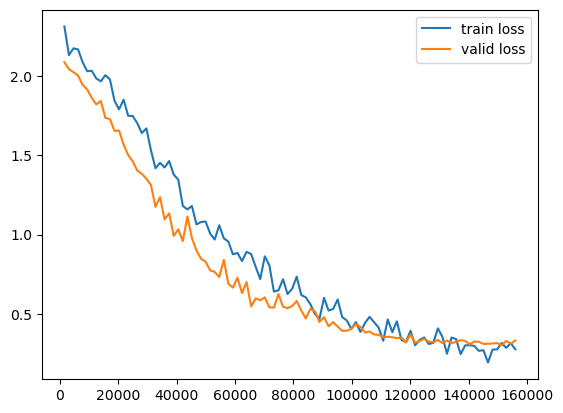

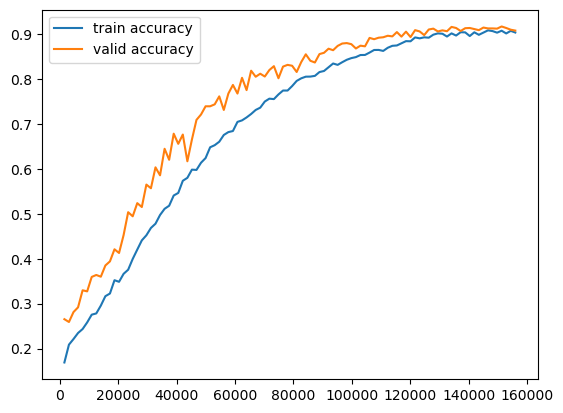

time: 3h 30min 46s (started: 2023-04-08 07:34:31 +00:00)


In [18]:
learn.fit_one_cycle(100, 3e-5, cbs=sp_cb)
                    
learn.recorder.custom_plot_losses()
learn.recorder.custom_plot_values()

In [23]:
learn.export(Path("/kaggle/working/VGG16_bn_accum8.pkl"))

time: 3.54 s (started: 2023-04-08 11:05:18 +00:00)
